##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 양자화 디버거로 양자화 오류 검사

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/performance/quantization_debugger"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

전체 정수 양자화는 향상된 모델 크기와 대기 시간을 제공하지만 양자화된 모델이 항상 예상대로 작동하지는 않습니다. 일반적으로 모델 품질(예: 정확도, mAP, WER)이 원래 float 모델보다 약간 낮을 것으로 예상됩니다. 그러나 모델 품질이 예상보다 낮거나 완전히 잘못된 결과를 생성하는 경우도 있을 수 있습니다.

이 문제가 발생하면 양자화 오류의 근본 원인을 찾는 것이 까다롭고 어려우며 양자화 오류를 수정하는 일은 훨씬 더 어렵습니다. 이 모델 검사 프로세스를 지원하는 방법으로, **양자화 디버거**를 사용하여 문제가 있는 레이어를 식별할 수 있고, **선택적 양자화**로는 이러한 문제가 있는 레이어를 부동 상태로 두어 양자화의 이점을 줄이면서 모델 정확도를 회복시킬 수 있습니다.

참고: 이 API는 실험적이며 개선 과정에서 API에 주요 변경이 있을 수 있습니다.

## 양자화 디버거

양자화 디버거를 사용하면 기존 모델에서 양자화 품질 메트릭 분석을 수행할 수 있습니다. 양자화 디버거는 디버그 데이터세트로 모델을 실행하고 각 텐서에 대한 양자화 품질 메트릭을 수집하는 프로세스를 자동화할 수 있습니다.

참고: 양자화 디버거 및 선택적 양자화는 현재 int8 활성화가 적용된 전체 정수 양자화에만 작동합니다.

### 전제 조건

모델을 양자화하기 위한 파이프라인이 이미 있는 경우, 양자화 디버거를 실행하는 데 필요한 모든 부분을 갖춘 것입니다!

- 양자화할 모델
- 대표적 데이터세트

모델 및 데이터 외에도 내보낸 결과를 분석하려면 데이터 처리 프레임워크(예: pandas, Google Sheets)를 사용해야 합니다.

### 설정

이 섹션에서는 100개 이미지의 라이브러리, MobileNet v3 모델 및 테스트 데이터세트를 준비합니다.

In [2]:
# Quantization debugger is available from TensorFlow 2.7.0
!pip uninstall -y tensorflow
!pip install tf-nightly
!pip install tensorflow_datasets --upgrade  # imagenet_v2 needs latest checksum

Found existing installation: tensorflow 2.11.0


Uninstalling tensorflow-2.11.0:


  Successfully uninstalled tensorflow-2.11.0


  Using cached tf_nightly-2.12.0.dev20221214-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (556.4 MB)


  Using cached jax-0.4.1-py3-none-any.whl


  Using cached tf_estimator_nightly-2.12.0.dev2022121409-py2.py3-none-any.whl (439 kB)


  Using cached tb_nightly-2.12.0a20221214-py3-none-any.whl (5.7 MB)


  Using cached keras_nightly-2.12.0.dev2022121408-py2.py3-none-any.whl (1.7 MB)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

2022-12-15 00:51:32.522769: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


In [4]:
#@title Boilerplates and helpers
MODEL_URI = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'


def process_image(data):
  data['image'] = tf.image.resize(data['image'], (224, 224)) / 255.0
  return data


# Representative dataset
def representative_dataset(dataset):

  def _data_gen():
    for data in dataset.batch(1):
      yield [data['image']]

  return _data_gen


def eval_tflite(tflite_model, dataset):
  """Evaluates tensorflow lite classification model with the given dataset."""
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_idx = interpreter.get_input_details()[0]['index']
  output_idx = interpreter.get_output_details()[0]['index']

  results = []

  for data in representative_dataset(dataset)():
    interpreter.set_tensor(input_idx, data[0])
    interpreter.invoke()
    results.append(interpreter.get_tensor(output_idx).flatten())

  results = np.array(results)
  gt_labels = np.array(list(dataset.map(lambda data: data['label'] + 1)))
  accuracy = (
      np.sum(np.argsort(results, axis=1)[:, -5:] == gt_labels.reshape(-1, 1)) /
      gt_labels.size)
  print(f'Top-5 accuracy (quantized): {accuracy * 100:.2f}%')


model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224, 224, 3), batch_size=1),
  hub.KerasLayer(MODEL_URI)
])
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics='sparse_top_k_categorical_accuracy')
model.build([1, 224, 224, 3])

# Prepare dataset with 100 examples
ds = tfds.load('imagenet_v2', split='test[:1%]')
ds = ds.map(process_image)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset(ds)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2gu_jpp1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2gu_jpp1/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 00:51:50.073304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:51:50.073352: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [5]:
test_ds = ds.map(lambda data: (data['image'], data['label'] + 1)).batch(16)
loss, acc = model.evaluate(test_ds)
print(f'Top-5 accuracy (float): {acc * 100:.2f}%')

1/7 [===>..........................] - ETA: 43s - loss: 5.6781 - sparse_top_k_categorical_accuracy: 0.7500

7/7 [==============================] - ETA: 0s - loss: 5.7098 - sparse_top_k_categorical_accuracy: 0.8200 

7/7 [==============================] - 8s 63ms/step - loss: 5.7098 - sparse_top_k_categorical_accuracy: 0.8200


Top-5 accuracy (float): 82.00%


In [6]:
eval_tflite(quantized_model, ds)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Top-5 accuracy (quantized): 51.00%


원본 모델이 우리의 작은 데이터세트에 대해 훨씬 더 높은 상위 5개 정확도를 갖는 반면 양자화된 모델은 상당한 정확도 손실을 가지고 있음을 알 수 있습니다.

### 1단계. 디버거 준비

양자화 디버거를 사용하는 가장 쉬운 방법은 모델을 양자화하는 데 사용 중인 `tf.lite.TFLiteConverter`를 제공하는 것입니다.

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset(ds)

# my_debug_dataset should have the same format as my_representative_dataset
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter, debug_dataset=representative_dataset(ds))

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkrx11lnu/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkrx11lnu/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 00:52:15.609440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:52:15.609489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


### 2단계. 디버거 실행 및 결과 가져오기

`QuantizationDebugger.run()`을 호출하면 디버거는 동일한 작업 위치에 대해 부동 텐서와 양자화된 텐서 간의 차이를 기록하고 지정된 메트릭으로 이를 처리합니다.

In [8]:
debugger.run()

처리된 메트릭은 `QuantizationDebugger.layer_statistics`를 사용하여 액세스하거나 `QuantizationDebugger.layer_statistics_dump()`를 사용하여 CSV 형식의 텍스트 파일에 덤프할 수 있습니다.

In [9]:
RESULTS_FILE = '/tmp/debugger_results.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

In [10]:
!head /tmp/debugger_results.csv

덤프의 각 행에 대해 연산 이름과 인덱스가 먼저 오고 양자화 매개변수와 오류 메트릭(있는 경우 [사용자 지정 오류 메트릭](#custom-metrics) 포함)이 뒤따릅니다. 결과적인 CSV 파일은 양자화 오류 메트릭이 큰 문제가 있는 레이어를 골라내는 데 사용할 수 있습니다.

팬더 또는 기타 데이터 처리 라이브러리를 사용하여 상세한 레이어별 오류 메트릭을 검사할 수 있습니다.

In [11]:
layer_stats = pd.read_csv(RESULTS_FILE)
layer_stats.head()

op_name  tensor_idx  num_elements        stddev  mean_error  \
0                MUL         227      150528.0  2.162354e-03   -0.000002   
1                SUB         231      150528.0  3.170321e-08    0.003922   
2            CONV_2D         235      200704.0  4.148779e-02    0.000216   
3         HARD_SWISH         239      200704.0  2.981238e-02   -0.000470   
4  DEPTHWISE_CONV_2D         243       50176.0  2.176653e-01   -0.022613   

   max_abs_error  mean_squared_error     scale  zero_point  \
0       0.003922            0.000005  0.007843        -128   
1       0.003922            0.000015  0.007843          -1   
2       0.102274            0.001726  0.142475         -30   
3       0.045249            0.000893  0.089297        -124   
4       0.723893            0.047961  0.508746        -128   

                                         tensor_name  
0        predict/hub_input/Mul;predict/hub_input/Mul  
1        predict/hub_input/Sub;predict/hub_input/Sub  
2  predict/MobilenetV3/Conv/BatchNorm/FusedBatchN...  
3  predict/MobilenetV3/Conv/hard_swish/mul_1;pred...  
4  predict/MobilenetV3/expanded_conv/depthwise/Re...

### 3단계. 데이터 분석

결과를 분석하는 방법은 다양합니다. 먼저 디버거의 출력에서 파생된 몇 가지 유용한 메트릭을 추가해 보겠습니다(`scale`은 각 텐서에 대한 양자화 스케일 팩터를 의미함).

- 범위(`256 / scale`)
- RMSE / 스케일(`sqrt(mean_squared_error) / scale`)

`RMSE / scale`은 양자화된 분포가 원래 float 분포와 유사할 때 `1 / sqrt(12)`(~ 0.289)에 가까우며 이는 양호한 양자화된 모델을 나타냅니다. 값이 클수록 레이어가 잘 양자화되지 않을 가능성이 높습니다.

In [12]:
layer_stats['range'] = 255.0 * layer_stats['scale']
layer_stats['rmse/scale'] = layer_stats.apply(
    lambda row: np.sqrt(row['mean_squared_error']) / row['scale'], axis=1)
layer_stats[['op_name', 'range', 'rmse/scale']].head()

op_name       range  rmse/scale
0                MUL    2.000000    0.276802
1                SUB    2.000000    0.499994
2            CONV_2D   36.331013    0.291630
3         HARD_SWISH   22.770702    0.334676
4  DEPTHWISE_CONV_2D  129.730204    0.430470

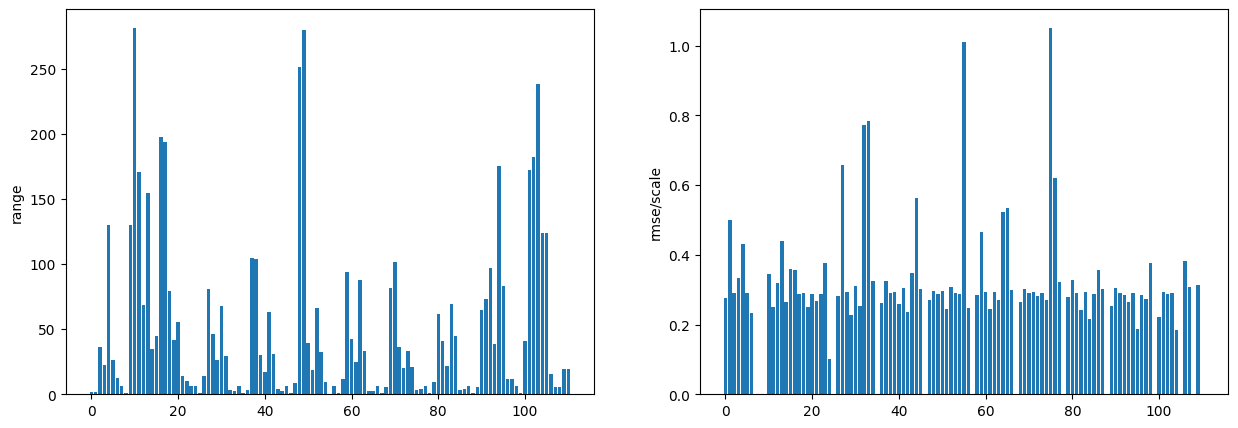

In [13]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
ax1.set_ylabel('range')
ax2 = plt.subplot(122)
ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
ax2.set_ylabel('rmse/scale')
plt.show()

범위가 넓은 레이어가 많고 `RMSE/scale` 값이 높은 레이어도 있습니다. 오류 메트릭이 높은 레이어를 가져오겠습니다.

In [14]:
layer_stats[layer_stats['rmse/scale'] > 0.7][[
    'op_name', 'range', 'rmse/scale', 'tensor_name'
]]

op_name     range  rmse/scale  \
32     MEAN  3.300810    0.771602   
33  CONV_2D  2.866467    0.784422   
55  CONV_2D  0.001957    1.011160   
75     MEAN  3.214616    1.051455   

                                          tensor_name  
32  predict/MobilenetV3/expanded_conv_4/squeeze_ex...  
33  predict/MobilenetV3/expanded_conv_4/squeeze_ex...  
55  predict/MobilenetV3/expanded_conv_6/squeeze_ex...  
75  predict/MobilenetV3/expanded_conv_8/squeeze_ex...

이러한 레이어를 사용하여 선택적 양자화를 시도하면 해당 레이어를 양자화하지 않았을 때 모델 품질이 향상되는지 확인할 수 있습니다.

In [15]:
suspected_layers = list(
    layer_stats[layer_stats['rmse/scale'] > 0.7]['tensor_name'])

이 외에도 처음 몇 개의 레이어에 대한 양자화를 건너뛰는 것도 양자화된 모델의 품질을 개선하는 데 도움이 됩니다.

In [16]:
suspected_layers.extend(list(layer_stats[:5]['tensor_name']))

## 선택적 양자화

선택적 양자화는 일부 노드에 대한 양자화를 건너뛰므로 원래 float 영역에서 계산이 이루어질 수 있습니다. 올바른 레이어를 건너뛰면 지연 시간과 모델 크기가 증가하는 대신 일부 모델 품질의 회복을 기대할 수 있습니다.

그러나 정수 전용 가속기(예: Hexagon DSP, EdgeTPU)에서 양자화된 모델을 실행할 계획이라면 선택적 양자화로 인해 모델이 단편화되고 주로 CPU와 해당 가속기 간의 데이터 전송 비용으로 인해 추론 지연 시간이 더 느려집니다. 이를 방지하기 위해 [양자화 인식 훈련](https://www.tensorflow.org/model_optimization/guide/quantization/training)을 실행하여 모델 정확도를 유지하면서 모든 계층을 정수로 유지하는 방법을 고려할 수 있습니다.

양자화 디버거의 옵션은 특정 레이어 또는 특정 작업의 모든 인스턴스에 대한 양자화를 건너뛰기 위한 `denylisted_nodes` 및 `denylisted_ops` 옵션을 허용합니다. 이전 단계에서 준비한 `suspected_layers`를 사용하여 양자화 디버거로 선택적으로 양자화된 모델을 얻을 수 있습니다.

In [17]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=suspected_layers)
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe8mx53jh/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe8mx53jh/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 00:52:37.914765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:52:37.914831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [18]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Top-5 accuracy (quantized): 65.00%


정확도는 원래 float 모델에 비해 여전히 낮지만 111개 레이어 중 ~10개 레이어에 대한 양자화를 건너뛰어 전체 양자화 모델에서 눈에 띄는 개선 효과를 거두었습니다.

같은 클래스의 모든 연산을 양자화하지 않는 방법도 시도할 수 있습니다. 예를 들어, 모든 평균 연산에 대한 양자화를 건너뛰려면 `MEAN`을 `denylisted_ops`에 전달할 수 있습니다.

In [19]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_ops=['MEAN'])
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp1crd2h5j/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp1crd2h5j/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2022-12-15 00:52:55.862828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:52:55.862874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [20]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Top-5 accuracy (quantized): 51.00%


이러한 기술을 통해 양자화된 MobileNet V3 모델 정확도를 향상시킬 수 있습니다. 다음으로, 모델 정확도를 더욱 향상시키는 고급 기술을 살펴보겠습니다.

## 고급 사용법

다음 기능을 사용하여 디버깅 파이프라인을 추가로 사용자 지정할 수 있습니다.

### 사용자 정의 메트릭

기본적으로, 양자화 디버거는 각 float-quant 차이에 대해 텐서 크기, 표준 편차, 평균 오차, 최대 절대 오차 및 평균 제곱 오차의 5가지 메트릭을 내보냅니다. 더 많은 사용자 지정 메트릭을 옵션으로 전달하여 이러한 메트릭을 추가할 수 있습니다. 각 메트릭에 대해 결과는 단일 float 값이어야 하며 결과 메트릭은 모든 예제의 메트릭 평균이 됩니다.

- `layer_debug_metrics`: float의 각 op 출력과 양자화된 op 출력의 차이를 기반으로 메트릭을 계산합니다.
- `layer_direct_compare_metrics`: diff만 가져오는 대신 원시 float 및 양자화된 텐서, 그리고 그 양자화 매개변수(스케일, 영점)를 기반으로 메트릭을 계산합니다.
- `model_debug_metrics`: **`float_model_(path|content)`가 디버거에 전달될 때만 사용됩니다**. Op 수준 메트릭 외에도 최종 레이어 출력은 원래 float 모델의 참조 출력과 비교됩니다.

In [21]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    layer_debug_metrics={
        'mean_abs_error': (lambda diff: np.mean(np.abs(diff)))
    },
    layer_direct_compare_metrics={
        'correlation':
            lambda f, q, s, zp: (np.corrcoef(f.flatten(),
                                             (q.flatten() - zp) / s)[0, 1])
    },
    model_debug_metrics={
        'argmax_accuracy': (lambda f, q: np.mean(np.argmax(f) == np.argmax(q)))
    })

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6ecj234g/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6ecj234g/assets


2022-12-15 00:53:13.946689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:53:13.946743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmptkcskjx7/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmptkcskjx7/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2022-12-15 00:53:23.771576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:53:23.771630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [22]:
debugger.run()

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2631: RuntimeWarning: invalid value encountered in cast
  X = array(m, ndmin=2, dtype=dtype)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/tools/optimize/debugging/python/debugger.py:382: RuntimeWarning: Mean of empty slice
  metrics[metric_name] = np.nanmean(metrics[metric_name])


In [23]:
CUSTOM_RESULTS_FILE = '/tmp/debugger_results.csv'
with open(CUSTOM_RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

custom_layer_stats = pd.read_csv(CUSTOM_RESULTS_FILE)
custom_layer_stats[['op_name', 'mean_abs_error', 'correlation']].tail()

op_name  mean_abs_error  correlation
106          CONV_2D    1.890278e-02     0.007164
107       HARD_SWISH    5.650395e-03    -0.000937
108  AVERAGE_POOL_2D    4.777645e-08     0.003867
109          CONV_2D    2.027273e-02     0.997327
110          RESHAPE    1.335906e-07     0.997489

`model_debug_metrics`의 결과는 `debugger.model_statistics`에서 별도로 볼 수 있습니다.

In [24]:
debugger.model_statistics

{'argmax_accuracy': 0.38}

### (내부) mlir_quantize API를 사용하여 심층 기능에 액세스

참고: 다음 섹션의 일부 기능인 `TFLiteConverter._experimental_calibrate_only` 및 `converter.mlir_quantize`는 실험적인 내부 API이며 이전 버전과 호환되지 않는 방식으로 변경될 수 있습니다.

In [25]:
from tensorflow.lite.python import convert

#### 전체 모델 검증 모드

디버그 모델 생성의 기본 동작은 레이어별 검증입니다. 이 모드에서 float 및 quantize 연산 쌍에 대한 입력은 동일한 소스(이전 양자화 연산)에서 가져옵니다. 또 다른 모드는 float 및 quantize 모델이 분리되는 전체 모델 검증입니다. 이 모드는 오류가 모델 후단으로 전파되는 방식을 관찰하는 데 유용합니다. 이를 위해 디버그 모델을 수동으로 생성하는 동안 `enable_whole_model_verify=True`를 `convert.mlir_quantize`로 설정합니다.

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset(ds)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter._experimental_calibrate_only = True
calibrated_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2yo3pmbc/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2yo3pmbc/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:778: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 00:53:55.984808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:53:55.984854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [27]:
# Note that enable_numeric_verify and enable_whole_model_verify are set.
quantized_model = convert.mlir_quantize(
    calibrated_model,
    enable_numeric_verify=True,
    enable_whole_model_verify=True)
debugger = tf.lite.experimental.QuantizationDebugger(
    quant_debug_model_content=quantized_model,
    debug_dataset=representative_dataset(ds))

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


#### 이미 보정된 모델에서 선택적 양자화

`convert.mlir_quantize`를 직접 호출하여 이미 보정된 모델에서 선택적 양자화된 모델을 가져올 수 있습니다. 이는 모델을 한 번 보정하고 다양한 거부 목록 조합을 실험하려는 경우에 특히 유용합니다.

In [28]:
selective_quantized_model = convert.mlir_quantize(
    calibrated_model, denylisted_nodes=suspected_layers)
eval_tflite(selective_quantized_model, ds)

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Top-5 accuracy (quantized): 65.00%
